In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MCC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

## Data Loading

In [13]:

url = 'https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json'
df = pd.read_json(url)

print(df.target_names.unique())
df.head(10)


['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


content  target  \
0  From: lerxst@wam.umd.edu (where's my thing)\nS...       7   
1  From: guykuo@carson.u.washington.edu (Guy Kuo)...       4   
2  From: twillis@ec.ecn.purdue.edu (Thomas E Will...       4   
3  From: jgreen@amber (Joe Green)\nSubject: Re: W...       1   
4  From: jcm@head-cfa.harvard.edu (Jonathan McDow...      14   
5  From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...      16   
6  From: bmdelane@quads.uchicago.edu (brian manni...      13   
7  From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: ...       3   
8  From: holmes7000@iscsvax.uni.edu\nSubject: WIn...       2   
9  From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...       4   

               target_names  
0                 rec.autos  
1     comp.sys.mac.hardware  
2     comp.sys.mac.hardware  
3             comp.graphics  
4                 sci.space  
5        talk.politics.guns  
6                   sci.med  
7  comp.sys.ibm.pc.hardware  
8   comp.os.ms-windows.misc  
9     comp.sys.mac.hardware

In [14]:
df.target.max()

19

In [15]:
df.target.value_counts()

target
10    600
15    599
8     598
9     597
11    595
7     594
13    594
5     593
14    593
2     591
12    591
3     590
6     585
1     584
4     578
17    564
16    546
0     480
18    465
19    377
Name: count, dtype: int64

In [16]:
df.shape

(11314, 3)

In [17]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def generate_wordcloud(text_list, max_words=200, background_color="white", colormap="viridis"):
    """
    Generates and displays a word cloud from a list of input texts.
    
    Parameters:
    text_list (list of str): The list of texts for generating the word cloud.
    max_words (int): The maximum number of words to include in the word cloud.
    background_color (str): The background color for the word cloud image.
    colormap (str): The colormap to use for the word cloud.
    
    Returns:
    None
    """
    # Combine the list of texts into a single string
    combined_text = " ".join(text_list)
    
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, max_words=max_words,
                          background_color=background_color, colormap=colormap).generate(combined_text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off the axis
    plt.show()


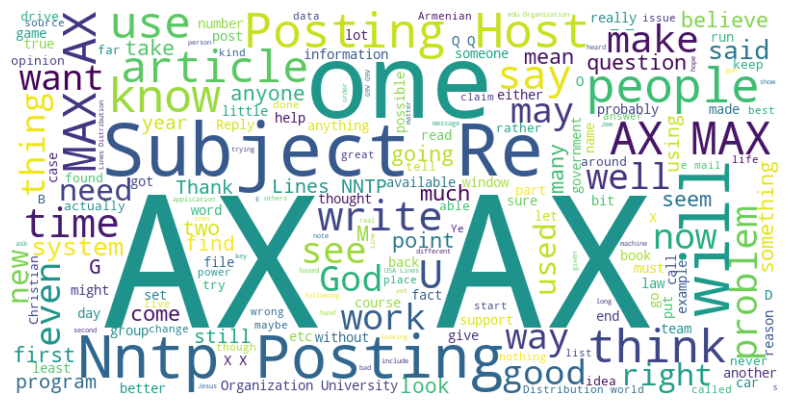

In [18]:
# In your new notebook
#from utilities import generate_wordcloud

generate_wordcloud(df.content)


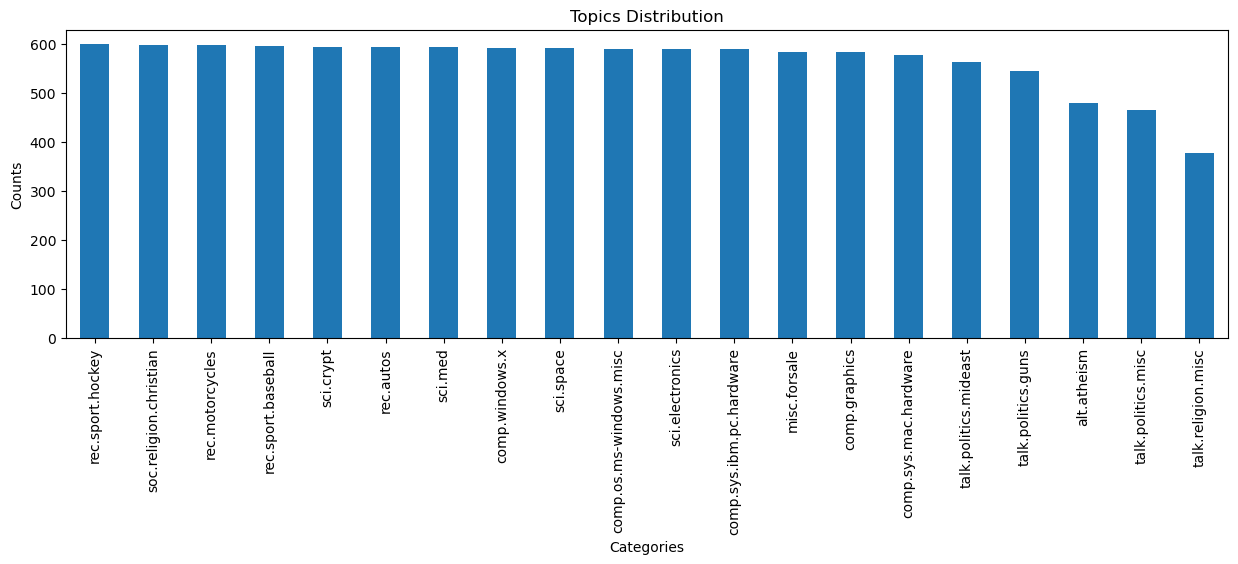

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
# Plot the bar plot
plt.figure(figsize=(15, 4))
df.target_names.value_counts().plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Topics Distribution')
plt.xticks(rotation=90)
plt.show()


# Text Preprocessing 

## Remove emails and newline characters

In [47]:
print(df.content.iloc[:1][0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [48]:
# Convert to list 
data = df.content.values.tolist()  
# Remove Emails 
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]  
# Remove new line characters 
data = [re.sub('\s+', ' ', sent) for sent in data]  
# Remove distracting single quotes 
data = [re.sub("\'", "", sent) for sent in data]  

pprint(data[:1])

<>:4: DeprecationWarning: invalid escape sequence '\S'
<>:6: DeprecationWarning: invalid escape sequence '\s'
<>:4: DeprecationWarning: invalid escape sequence '\S'
<>:6: DeprecationWarning: invalid escape sequence '\s'
C:\Users\MCC\AppData\Local\Temp\ipykernel_16880\1025570194.py:4: DeprecationWarning: invalid escape sequence '\S'
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
C:\Users\MCC\AppData\Local\Temp\ipykernel_16880\1025570194.py:6: DeprecationWarning: invalid escape sequence '\s'
  data = [re.sub('\s+', ' ', sent) for sent in data]


['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [51]:
# Use gensims simple_preprocess(), set deacc=True to remove punctuations.
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


## Remove Stopwords

In [52]:
# Define function for stopwords, bigrams, trigrams and lemmatization
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]



In [53]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [59]:

data_words_nostops

[['wheres',
  'thing',
  'car',
  'nntp',
  'posting',
  'host',
  'rac',
  'wam',
  'umd',
  'organization',
  'university',
  'maryland',
  'college',
  'park',
  'lines',
  'wondering',
  'anyone',
  'could',
  'enlighten',
  'car',
  'saw',
  'day',
  'door',
  'sports',
  'car',
  'looked',
  'late',
  'early',
  'called',
  'bricklin',
  'doors',
  'really',
  'small',
  'addition',
  'front',
  'bumper',
  'separate',
  'rest',
  'body',
  'know',
  'anyone',
  'tellme',
  'model',
  'name',
  'engine',
  'specs',
  'years',
  'production',
  'car',
  'made',
  'history',
  'whatever',
  'info',
  'funky',
  'looking',
  'car',
  'please',
  'mail',
  'thanks',
  'il',
  'brought',
  'neighborhood',
  'lerxst'],
 ['guy',
  'kuo',
  'si',
  'clock',
  'poll',
  'final',
  'call',
  'summary',
  'final',
  'call',
  'si',
  'clock',
  'reports',
  'keywords',
  'si',
  'acceleration',
  'clock',
  'upgrade',
  'article',
  'shelley',
  'qvfo',
  'innc',
  'organization',
  'univer

In [64]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(lists_of_words, width=800, height=400, background_color='white'):
    """
    Generates and displays a word cloud from a list of lists of words.

    Parameters:
    lists_of_words (list of list of str): The input list of lists of words.
    width (int): The width of the word cloud image.
    height (int): The height of the word cloud image.
    background_color (str): The background color of the word cloud image.
    """
    # Flatten the list of lists
    flat_list = [word for sublist in lists_of_words for word in sublist]

    # Create a string with all words separated by spaces
    text = ' '.join(flat_list)

    # Generate the word cloud
    wordcloud = WordCloud(width=width, height=height, background_color=background_color).generate(text)

    # Display the word cloud
    plt.figure(figsize=(width / 80, height / 80))  # Convert pixels to inches for figure size
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()






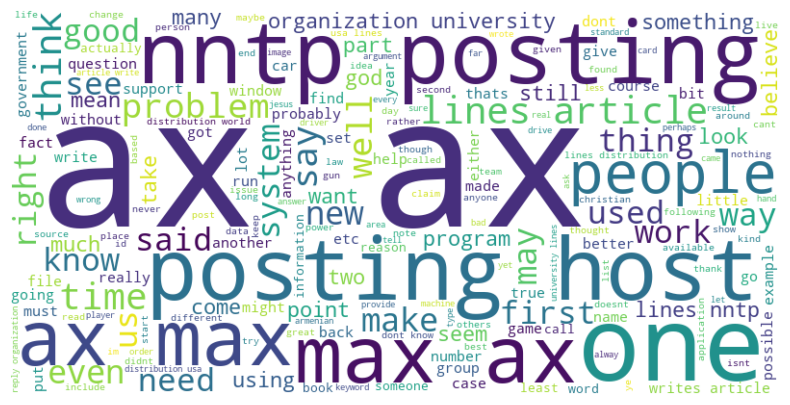

In [65]:

generate_word_cloud(data_words_nostops)

## Creating Bigram and Trigram models

In [66]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [67]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [69]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

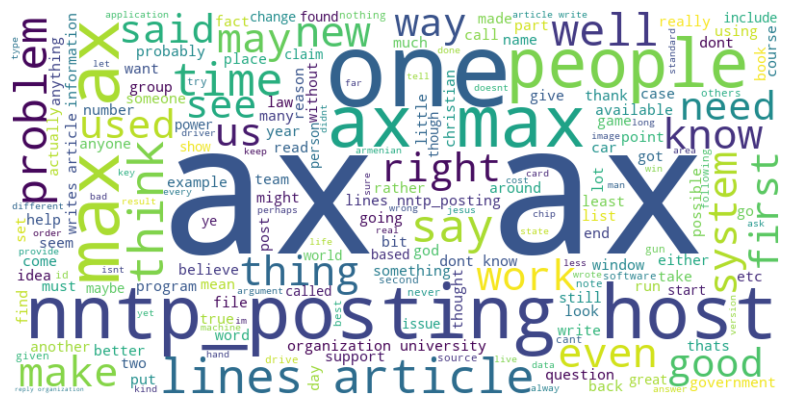

In [70]:
generate_word_cloud(data_words_bigrams)

In [71]:
# Form Bigrams
data_words_trigrams = make_trigrams(data_words_bigrams)

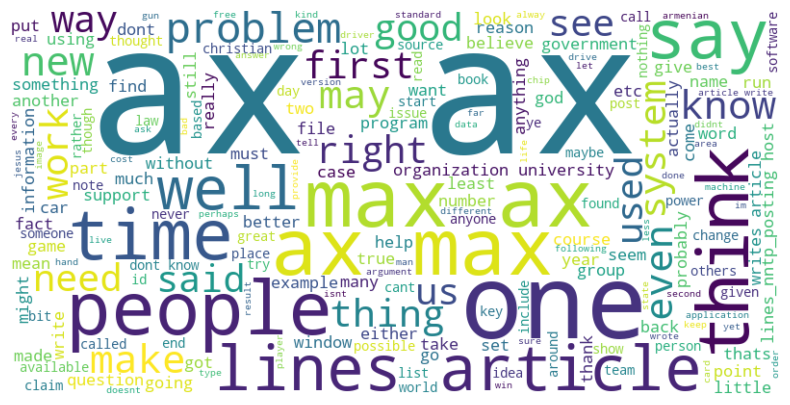

In [72]:

generate_word_cloud(data_words_trigrams)

## Lemmatization

In [73]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [74]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['s', 'thing', 'car', 'nntp_poste', 'host', 'rac_wam', 'university', 'park', 'line', 'wonder', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


## Create Dictionary and Corpus 

In [41]:
# Needed for Topic Modeling

In [75]:
# Create Dictionary 
id2word = corpora.Dictionary(data_lemmatized)  


In [76]:
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]]


In [77]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('rac_wam', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('thank', 1),
  ('thing', 1),
  ('university', 1),
  ('wonder', 1),
  ('year', 1)]]

# LDA Model

In [78]:
# Alpha and Beta are Hyperparameters 
# Alpha represents document-topic density 
# Beta represents topic-word density
# chunksize is the number of documents to be used in each training chunk
# update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [79]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=19, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Visualization

In [80]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis                                                               

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.340875 -0.092961       1        1  27.073761
18     0.306592  0.053144       2        1  21.698097
13     0.267107 -0.199648       3        1  12.575400
12     0.193323  0.161109       4        1   8.295231
6     -0.021471  0.043212       5        1   5.936518
9      0.111768 -0.065741       6        1   5.428644
10     0.048806  0.260397       7        1   3.629253
11     0.031373  0.190506       8        1   3.318645
1      0.030651 -0.168599       9        1   2.435191
7     -0.021308  0.058878      10        1   2.044240
5     -0.030253 -0.140142      11        1   1.478263
2     -0.085694  0.025086      12        1   1.475765
0     -0.110888 -0.006063      13        1   1.375563
16    -0.139702 -0.031259      14        1   1.097458
15    -0.092676  0.071842      15        1   1.041630
4     -0.176393 -0.038569      16        1   0.680675
8     -0.204461 -0.041966      17        1   0.324108
17    -0.223529 -0.039581      18        1   0.060807
14    -0.224121 -0.039647      19        1   0.030750, topic_info=                 Term          Freq         Total Category  logprob  loglift
4399               ax  47862.000000  47862.000000  Default  30.0000  30.0000
17               line  16849.000000  16849.000000  Default  29.0000  29.0000
208             write  13383.000000  13383.000000  Default  28.0000  28.0000
142      organization   9325.000000   9325.000000  Default  27.0000  27.0000
45            article   9830.000000   9830.000000  Default  26.0000  26.0000
...               ...           ...           ...      ...      ...      ...
7247  law_enforcement      0.006978      1.236897  Topic19 -10.9485   2.9095
6293             root      0.006978      1.236837  Topic19 -10.9486   2.9095
5170       connection      0.006978      1.236973  Topic19 -10.9485   2.9094
6564     transmission      0.006978      1.236864  Topic19 -10.9485   2.9094
5680            valid      0.006978      1.237123  Topic19 -10.9485   2.9092

[841 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
495      11  0.991441  absolute
1354      1  0.791782    accept
1354     11  0.207052    accept
86        2  0.754166    access
86       15  0.244155    access
...     ...       ...       ...
40        2  0.716156      year
40        9  0.015774      year
614       6  0.969863     young
614       9  0.028327     young
2633     14  0.993293      zone

[1041 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 19, 14, 13, 7, 10, 11, 12, 2, 8, 6, 3, 1, 17, 16, 5, 9, 18, 15])

# Evaluation

In [81]:
# Lower the perplexity better the model.
# Higher the topic coherence, the topic is more human interpretable.

In [82]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.997372458867343

Coherence Score:  0.5010643865717771


In [ ]:
# Elbow 

https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920